In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import dem_functions as df
import bikeability_functions as bf
import contextily as cx
import pandas as pd
import yan_helper_functions as yhf

c:\Users\ckaz3\.virtualenvs\equitable-cycling-networks-HQaIwDgz\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [10]:
def dem_features(dem):
    dem['frac_pop_nonwhite'] = (dem['total_pop']-dem['total_pop_white'])/dem['total_pop']
    dem['frac_below_poverty'] = dem['below_poverty']/dem['total_pop']
    dem['frac_no_car'] = dem['zero_vehicles']/dem['total_workers']

def quint_curves(G,quant_of_int,var,betas=np.linspace(0.01,10,200)):
    var_low = bf.compute_bikeability_curves(G,quant_of_int[var][0])
    var_high = bf.compute_bikeability_curves(G,quant_of_int[var][1])
    
    curve_1=bf.network_wide_bikeability_curve(betas, var_low)
    curve_2=bf.network_wide_bikeability_curve(betas, var_high)
    
    return curve_1,curve_2

In [2]:
def load_sf_data():
    acs_vars = {'B02001_001E':'total_pop','B02001_002E':'total_pop_white',
                'B19013_001E':'median_hh_income','B06012_002E':'below_poverty',
                'B08014_001E':'total_workers','B08014_002E':'zero_vehicles'}

    G_SF = bf.load_graph('data/V2_SF_coarse_graph_cluster')
    dem_SF = df.get_dem('San Francisco,CA',acs_vars)

    dem_features(dem_SF)

    return G_SF, dem_SF

In [ ]:
def calc_metrics(G, dem_SF, total_length_added, num_cc) -> pd.DataFrame:
    betas = np.linspace(0.01,10,200)
    curves_SF = bf.compute_bikeability_curves(G, G.nodes(), dest='all')
    user_dict_SF = bf.network_wide_bikeability_curve(betas, curves_SF)

    keys = ['frac_pop_nonwhite','frac_below_poverty','median_hh_income','frac_no_car']
    quant_of_int = df.all_quants(keys, dem_SF)
    nonwhite_low, nonwhite_high = quint_curves(G,quant_of_int,'frac_pop_nonwhite')
    poverty_low, poverty_high = quint_curves(G,quant_of_int,'frac_below_poverty')
    income_low, income_high = quint_curves(G,quant_of_int,'median_hh_income')
    carless_low, carless_high = quint_curves(G,quant_of_int,'frac_no_car')
    
    new_row = {'length_added_bikelanes': total_length_added, 
        'number_cc': num_cc,
        'overall_score': bf.calc_elbow(user_dict_SF), 
        'nonwhite_high': bf.calc_elbow(nonwhite_high),
        'nonwhite_low': bf.calc_elbow(nonwhite_low),
        'poverty_high': bf.calc_elbow(poverty_high),
        'poverty_low': bf.calc_elbow(poverty_low),
        'income_high': bf.calc_elbow(income_high),
        'income_low': bf.calc_elbow(income_low),
        'carless_high': bf.calc_elbow(carless_high),
        'carless_low': bf.calc_elbow(carless_low)}

    return pd.DataFrame([new_row])

In [85]:
G, dem = load_sf_data()

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\cycling-equity-master\cycling-equity-master\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [86]:
# isolate bike network
G_bikelanes = nx.DiGraph()  # graph of all bikelanes
G_bikelanes.add_nodes_from(G.nodes(data=True))

# create bikelane and potential bikelane networks
for start_node, end_node, data in G.edges(data=True):
    if not np.isnan(data["distance"][0]):
        G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

In [87]:
import yan_helper_functions as yhf
G, dem = yhf.load_sf_data()

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\cycling-equity-master\cycling-equity-master\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [88]:
G_bikelanes.edges(data=True)

OutEdgeDataView([('035100', '035300', {'distance': 1537.7359999999999}), ('035201', '035400', {'distance': 2473.947444444444}), ('980300', '045100', {'distance': 43.136}), ('980300', '030101', {'distance': 326.54425000000003}), ('980300', '032601', {'distance': 31.7485}), ('980300', '045200', {'distance': 130.74312500000002}), ('980300', '047901', {'distance': 561.429}), ('980300', '047702', {'distance': 522.2190714285715}), ('980300', '016500', {'distance': 1170.8032500000002}), ('980300', '032700', {'distance': 1232.7576315789474}), ('980300', '047600', {'distance': 298.16866666666664}), ('980300', '047801', {'distance': 162.516}), ('042700', '042800', {'distance': 1340.0294999999999}), ('980200', '047901', {'distance': 533.01635}), ('980200', '042800', {'distance': 1313.9995}), ('047801', '980300', {'distance': 162.51600000000002}), ('042800', '042700', {'distance': 1340.0295}), ('042800', '980200', {'distance': 1313.9995000000004}), ('030202', '030101', {'distance': 401.84475}), ('

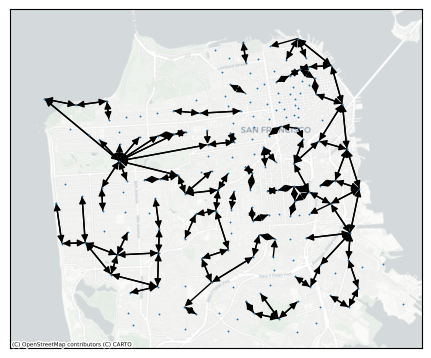

In [91]:
plt.style.use("seaborn-v0_8-paper")
fig, ax = plt.subplots()

coords = [nx.get_node_attributes(G, "x"), nx.get_node_attributes(G, "y")]
node_pos = {}

for k in coords[0].keys():
    node_pos[k] = tuple(d[k] for d in coords)

nx.number_strongly_connected_components(G_bikelanes)

# nx.draw_networkx_edges(G_bikelanes, pos=node_pos, arrowsize=6.6, width=0.66, ax=ax)
nx.draw_networkx(G_bikelanes, pos=node_pos, node_size=1, with_labels=False, ax=ax)
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, attribution_size=4)

In [18]:
# test
G, dem = load_sf_data()

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\cycling-equity-master\cycling-equity-master\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


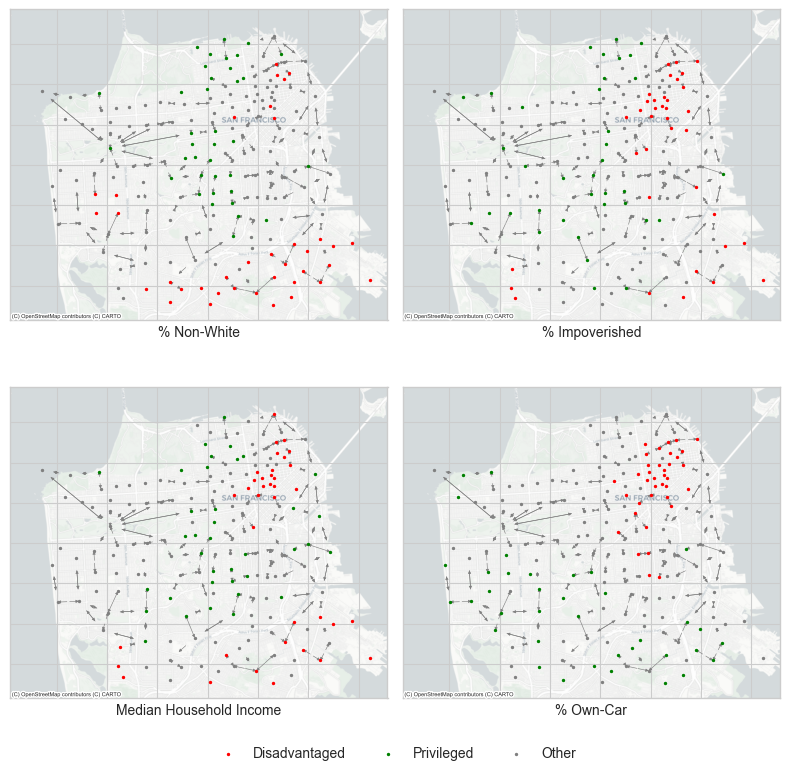

In [6]:
G_SF, dem_SF = yhf.load_sf_data()

# graph of all bikelanes
G_bikelanes = nx.DiGraph()

# create bikelane and potential bikelane networks
for start_node, end_node, data in G_SF.edges(data=True):
    if not np.isnan(data["distance"][0]):
        G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

keys = ["frac_pop_nonwhite", "frac_below_poverty", "median_hh_income", "frac_no_car"]
key_labels = ["% Non-White", "% Impoverished", 
              "Median Household Income", 
              "% Own-Car"]

plt.style.use("seaborn-v0_8-whitegrid")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)

for j, key in enumerate(keys):

    if key in ["median_hh_income"]:
        dis_nodes, priv_nodes = df.all_quants([key], dem_SF)[key]

    else:
        priv_nodes, dis_nodes = df.all_quants([key], dem_SF)[key]

    other_nodes = []

    for node in G_SF.nodes:
        if node not in dis_nodes and node not in priv_nodes:
            other_nodes.append(node)

    coords = [nx.get_node_attributes(G_SF, "x"), nx.get_node_attributes(G_SF, "y")]
    node_pos = {}

    for k in coords[0].keys():
        node_pos[k] = tuple(d[k] for d in coords)

    nx.draw_networkx_edges(
        G_bikelanes,
        edge_color="gray",
        pos=node_pos,
        arrowsize=4.4,
        width=0.44,
        ax=axs[j // 2][j % 2],
        label="Existing Bike Lanes",
    )
    nx.draw_networkx_nodes(
        G_SF,
        pos=node_pos,
        ax=axs[j // 2][j % 2],
        nodelist=dis_nodes,
        node_color="red",
        node_size=2,
        label="Privileged",
    )
    nx.draw_networkx_nodes(
        G_SF,
        pos=node_pos,
        ax=axs[j // 2][j % 2],
        nodelist=priv_nodes,
        node_color="green",
        node_size=2,
        label="Disadvantaged",
    )
    nx.draw_networkx_nodes(
        G_SF,
        pos=node_pos,
        ax=axs[j // 2][j % 2],
        nodelist=other_nodes,
        node_color="gray",
        node_size=2,
        label="Other",
    )
    cx.add_basemap(
        ax=axs[j // 2][j % 2], source=cx.providers.CartoDB.Positron, attribution_size=4
    )
    axs[j // 2][j % 2].set_xlabel(key_labels[j])

handles, labels = axs[0][0].get_legend_handles_labels()

unique_labels = [
    "Disadvantaged",
    "Privileged",
    "Other",
]

unique_handles = [
    handle for handle, label in zip(handles, labels) if label in unique_labels
]

fig.legend(
    handles=unique_handles,
    labels=unique_labels,
    loc="center",
    bbox_to_anchor=(0.5, 0),
    ncol=3,
)

plt.tight_layout()
plt.savefig("figures/initial_sf_network")